<!--NAVIGATION-->
< [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb) | [Contents](Index.ipynb) | [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.03-Computation-on-arrays-ufuncs.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Computation on NumPy Arrays: Universal Functions

Up until now, we have been discussing some of the basic nuts and bolts of NumPy; in the next few sections, we will dive into the reasons that NumPy is so important in the Python data science world.
Namely, it provides an easy and flexible interface to optimized computation with arrays of data.

Computation on NumPy arrays can be very fast, or it can be very slow.
The key to making it fast is to use *vectorized* operations, generally implemented through NumPy's *universal functions* (ufuncs).
This section motivates the need for NumPy's ufuncs, which can be used to make repeated calculations on array elements much more efficient.
It then introduces many of the most common and useful arithmetic ufuncs available in the NumPy package.

## The Slowness of Loops

Python's default implementation (known as CPython) does some operations very slowly.
This is in part due to the dynamic, interpreted nature of the language: the fact that types are flexible, so that sequences of operations cannot be compiled down to efficient machine code as in languages like C and Fortran.
Recently there have been various attempts to address this weakness: well-known examples are the [PyPy](http://pypy.org/) project, a just-in-time compiled implementation of Python; the [Cython](http://cython.org) project, which converts Python code to compilable C code; and the [Numba](http://numba.pydata.org/) project, which converts snippets of Python code to fast LLVM bytecode.
Each of these has its strengths and weaknesses, but it is safe to say that none of the three approaches has yet surpassed the reach and popularity of the standard CPython engine.

The relative sluggishness of Python generally manifests itself in situations where many small operations are being repeated – for instance looping over arrays to operate on each element.
For example, imagine we have an array of values and we'd like to compute the reciprocal of each.
A straightforward approach might look like this:

In [2]:
import numpy as np
#np.random.seed(0)

def compute_reciprocals(values):
    output = np.empty(len(values))
    for i in range(len(values)):
        output[i] = 1.0 / values[i]
    return output
        
values = np.random.randint(1, 10, size=5)
compute_reciprocals(values)

array([0.125     , 0.2       , 0.33333333, 0.11111111, 1.        ])

This implementation probably feels fairly natural to someone from, say, a C or Java background.
But if we measure the execution time of this code for a large input, we see that this operation is very slow, perhaps surprisingly so!
We'll benchmark this with IPython's ``%timeit`` magic (discussed in [Profiling and Timing Code](01.07-Timing-and-Profiling.ipynb)):

In [3]:
big_array = np.random.randint(1, 100, size=1000000)
%timeit compute_reciprocals(big_array)

5.01 s ± 851 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes several seconds to compute these million operations and to store the result!
When even cell phones have processing speeds measured in Giga-FLOPS (i.e., billions of numerical operations per second), this seems almost absurdly slow.
It turns out that the bottleneck here is not the operations themselves, but the type-checking and function dispatches that CPython must do at each cycle of the loop.
Each time the reciprocal is computed, Python first examines the object's type and does a dynamic lookup of the correct function to use for that type.
If we were working in compiled code instead, this type specification would be known before the code executes and the result could be computed much more efficiently.

## Introducing UFuncs

For many types of operations, NumPy provides a convenient interface into just this kind of statically typed, compiled routine. This is known as a *vectorized* operation.
This can be accomplished by simply performing an operation on the array, which will then be applied to each element.
This vectorized approach is designed to push the loop into the compiled layer that underlies NumPy, leading to much faster execution.

Compare the results of the following two:

In [4]:
print(compute_reciprocals(values))
print(1.0 / values)

[0.125      0.2        0.33333333 0.11111111 1.        ]
[0.125      0.2        0.33333333 0.11111111 1.        ]


Looking at the execution time for our big array, we see that it completes orders of magnitude faster than the Python loop:

In [5]:
%timeit (1.0 / big_array)

10.6 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Vectorized operations in NumPy are implemented via *ufuncs*, whose main purpose is to quickly execute repeated operations on values in NumPy arrays.
Ufuncs are extremely flexible – before we saw an operation between a scalar and an array, but we can also operate between two arrays:

In [5]:
np.arange(5) / np.arange(1, 6)

array([ 0.        ,  0.5       ,  0.66666667,  0.75      ,  0.8       ])

And ufunc operations are not limited to one-dimensional arrays–they can also act on multi-dimensional arrays as well:

In [6]:
x = np.arange(9).reshape((3, 3))
2 ** x

array([[  1,   2,   4],
       [  8,  16,  32],
       [ 64, 128, 256]])

In [12]:
import numpy as np
x = int(input('Number of elements in an array '))
m = int(input('size of matrix in m '))
n = int(input('size of matrix in n '))
c = np.arange(x).reshape(m,n)
print(c)

Number of elements in an array 9
size of matrix in m 3
size of matrix in n 3
[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [9]:
t

[',']

Computations using vectorization through ufuncs are nearly always more efficient than their counterpart implemented using Python loops, especially as the arrays grow in size.
Any time you see such a loop in a Python script, you should consider whether it can be replaced with a vectorized expression.

## Exploring NumPy's UFuncs

Ufuncs exist in two flavors: *unary ufuncs*, which operate on a single input, and *binary ufuncs*, which operate on two inputs.
We'll see examples of both these types of functions here.

### Array arithmetic

NumPy's ufuncs feel very natural to use because they make use of Python's native arithmetic operators.
The standard addition, subtraction, multiplication, and division can all be used:

In [13]:
x = np.arange(4)
print("x     =", x)
print("x + 5 =", x + 5)
print("x - 5 =", x - 5)
print("x * 2 =", x * 2)
print("x / 2 =", x / 2)
print("x // 2 =", x // 2)  # floor division

x     = [0 1 2 3]
x + 5 = [5 6 7 8]
x - 5 = [-5 -4 -3 -2]
x * 2 = [0 2 4 6]
x / 2 = [0.  0.5 1.  1.5]
x // 2 = [0 0 1 1]


There is also a unary ufunc for negation, and a ``**`` operator for exponentiation, and a ``%`` operator for modulus:

In [8]:
print("-x     = ", -x)
print("x ** 2 = ", x ** 2)
print("x % 2  = ", x % 2)

-x     =  [ 0 -1 -2 -3]
x ** 2 =  [0 1 4 9]
x % 2  =  [0 1 0 1]


In addition, these can be strung together however you wish, and the standard order of operations is respected:

In [9]:
-(0.5*x + 1) ** 2

array([-1.  , -2.25, -4.  , -6.25])

Each of these arithmetic operations are simply convenient wrappers around specific functions built into NumPy; for example, the ``+`` operator is a wrapper for the ``add`` function:

In [10]:
np.add(x, 2)

array([2, 3, 4, 5])

The following table lists the arithmetic operators implemented in NumPy:

| Operator	    | Equivalent ufunc    | Description                           |
|---------------|---------------------|---------------------------------------|
|``+``          |``np.add``           |Addition (e.g., ``1 + 1 = 2``)         |
|``-``          |``np.subtract``      |Subtraction (e.g., ``3 - 2 = 1``)      |
|``-``          |``np.negative``      |Unary negation (e.g., ``-2``)          |
|``*``          |``np.multiply``      |Multiplication (e.g., ``2 * 3 = 6``)   |
|``/``          |``np.divide``        |Division (e.g., ``3 / 2 = 1.5``)       |
|``//``         |``np.floor_divide``  |Floor division (e.g., ``3 // 2 = 1``)  |
|``**``         |``np.power``         |Exponentiation (e.g., ``2 ** 3 = 8``)  |
|``%``          |``np.mod``           |Modulus/remainder (e.g., ``9 % 4 = 1``)|

Additionally there are Boolean/bitwise operators; we will explore these in [Comparisons, Masks, and Boolean Logic](02.06-Boolean-Arrays-and-Masks.ipynb).

### Absolute value

Just as NumPy understands Python's built-in arithmetic operators, it also understands Python's built-in absolute value function:

In [11]:
x = np.array([-2, -1, 0, 1, 2])
abs(x)

array([2, 1, 0, 1, 2])

The corresponding NumPy ufunc is ``np.absolute``, which is also available under the alias ``np.abs``:

In [12]:
np.absolute(x)

array([2, 1, 0, 1, 2])

In [13]:
np.abs(x)

array([2, 1, 0, 1, 2])

This ufunc can also handle complex data, in which the absolute value returns the magnitude:

In [14]:
x = np.array([3 - 4j, 4 - 3j, 2 + 0j, 0 + 1j])
np.abs(x)

array([ 5.,  5.,  2.,  1.])

### Trigonometric functions

NumPy provides a large number of useful ufuncs, and some of the most useful for the data scientist are the trigonometric functions.
We'll start by defining an array of angles:

In [15]:
theta = np.linspace(0, np.pi, 3)

Now we can compute some trigonometric functions on these values:

In [16]:
print("theta      = ", theta)
print("sin(theta) = ", np.sin(theta))
print("cos(theta) = ", np.cos(theta))
print("tan(theta) = ", np.tan(theta))

theta      =  [0.         1.57079633 3.14159265]
sin(theta) =  [0.0000000e+00 1.0000000e+00 1.2246468e-16]
cos(theta) =  [ 1.000000e+00  6.123234e-17 -1.000000e+00]
tan(theta) =  [ 0.00000000e+00  1.63312394e+16 -1.22464680e-16]


The values are computed to within machine precision, which is why values that should be zero do not always hit exactly zero.
Inverse trigonometric functions are also available:

In [17]:
x = [-1, 0, 1]
print("x         = ", x)
print("arcsin(x) = ", np.arcsin(x))
print("arccos(x) = ", np.arccos(x))
print("arctan(x) = ", np.arctan(x))

x         =  [-1, 0, 1]
arcsin(x) =  [-1.57079633  0.          1.57079633]
arccos(x) =  [ 3.14159265  1.57079633  0.        ]
arctan(x) =  [-0.78539816  0.          0.78539816]


### Exponents and logarithms

Another common type of operation available in a NumPy ufunc are the exponentials:

In [18]:
x = [1, 2, 3]
print("x     =", x)
print("e^x   =", np.exp(x))
print("2^x   =", np.exp2(x))
print("3^x   =", np.power(3, x))

x     = [1, 2, 3]
e^x   = [  2.71828183   7.3890561   20.08553692]
2^x   = [ 2.  4.  8.]
3^x   = [ 3  9 27]


The inverse of the exponentials, the logarithms, are also available.
The basic ``np.log`` gives the natural logarithm; if you prefer to compute the base-2 logarithm or the base-10 logarithm, these are available as well:

In [19]:
x = [1, 2, 4, 10]
print("x        =", x)
print("ln(x)    =", np.log(x))
print("log2(x)  =", np.log2(x))
print("log10(x) =", np.log10(x))

x        = [1, 2, 4, 10]
ln(x)    = [ 0.          0.69314718  1.38629436  2.30258509]
log2(x)  = [ 0.          1.          2.          3.32192809]
log10(x) = [ 0.          0.30103     0.60205999  1.        ]


There are also some specialized versions that are useful for maintaining precision with very small input:

In [20]:
x = [0, 0.001, 0.01, 0.1]
print("exp(x) - 1 =", np.expm1(x))
print("log(1 + x) =", np.log1p(x))

exp(x) - 1 = [ 0.          0.0010005   0.01005017  0.10517092]
log(1 + x) = [ 0.          0.0009995   0.00995033  0.09531018]


When ``x`` is very small, these functions give more precise values than if the raw ``np.log`` or ``np.exp`` were to be used.

### Specialized ufuncs

NumPy has many more ufuncs available, including hyperbolic trig functions, bitwise arithmetic, comparison operators, conversions from radians to degrees, rounding and remainders, and much more.
A look through the NumPy documentation reveals a lot of interesting functionality.

Another excellent source for more specialized and obscure ufuncs is the submodule ``scipy.special``.
If you want to compute some obscure mathematical function on your data, chances are it is implemented in ``scipy.special``.
There are far too many functions to list them all, but the following snippet shows a couple that might come up in a statistics context:

In [21]:
from scipy import special

In [22]:
# Gamma functions (generalized factorials) and related functions
x = [1, 5, 10]
print("gamma(x)     =", special.gamma(x))
print("ln|gamma(x)| =", special.gammaln(x))
print("beta(x, 2)   =", special.beta(x, 2))

gamma(x)     = [  1.00000000e+00   2.40000000e+01   3.62880000e+05]
ln|gamma(x)| = [  0.           3.17805383  12.80182748]
beta(x, 2)   = [ 0.5         0.03333333  0.00909091]


In [23]:
# Error function (integral of Gaussian)
# its complement, and its inverse
x = np.array([0, 0.3, 0.7, 1.0])
print("erf(x)  =", special.erf(x))
print("erfc(x) =", special.erfc(x))
print("erfinv(x) =", special.erfinv(x))

erf(x)  = [ 0.          0.32862676  0.67780119  0.84270079]
erfc(x) = [ 1.          0.67137324  0.32219881  0.15729921]
erfinv(x) = [ 0.          0.27246271  0.73286908         inf]


There are many, many more ufuncs available in both NumPy and ``scipy.special``.
Because the documentation of these packages is available online, a web search along the lines of "gamma function python" will generally find the relevant information.

## Advanced Ufunc Features

Many NumPy users make use of ufuncs without ever learning their full set of features.
We'll outline a few specialized features of ufuncs here.

### Specifying output

For large calculations, it is sometimes useful to be able to specify the array where the result of the calculation will be stored.
Rather than creating a temporary array, this can be used to write computation results directly to the memory location where you'd like them to be.
For all ufuncs, this can be done using the ``out`` argument of the function:

In [24]:
x = np.arange(5)
y = np.empty(5)
np.multiply(x, 10, out=y)
print(y)

[  0.  10.  20.  30.  40.]


This can even be used with array views. For example, we can write the results of a computation to every other element of a specified array:

In [25]:
y = np.zeros(10)
np.power(2, x, out=y[::2])
print(y)

[  1.   0.   2.   0.   4.   0.   8.   0.  16.   0.]


If we had instead written ``y[::2] = 2 ** x``, this would have resulted in the creation of a temporary array to hold the results of ``2 ** x``, followed by a second operation copying those values into the ``y`` array.
This doesn't make much of a difference for such a small computation, but for very large arrays the memory savings from careful use of the ``out`` argument can be significant.

### Aggregates

For binary ufuncs, there are some interesting aggregates that can be computed directly from the object.
For example, if we'd like to *reduce* an array with a particular operation, we can use the ``reduce`` method of any ufunc.
A reduce repeatedly applies a given operation to the elements of an array until only a single result remains.

For example, calling ``reduce`` on the ``add`` ufunc returns the sum of all elements in the array:

In [26]:
x = np.arange(1, 6)
np.add.reduce(x)

15

Similarly, calling ``reduce`` on the ``multiply`` ufunc results in the product of all array elements:

In [27]:
np.multiply.reduce(x)

120

If we'd like to store all the intermediate results of the computation, we can instead use ``accumulate``:

In [28]:
np.add.accumulate(x)

array([ 1,  3,  6, 10, 15])

In [29]:
np.multiply.accumulate(x)

array([  1,   2,   6,  24, 120])

Note that for these particular cases, there are dedicated NumPy functions to compute the results (``np.sum``, ``np.prod``, ``np.cumsum``, ``np.cumprod``), which we'll explore in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb).

### Outer products

Finally, any ufunc can compute the output of all pairs of two different inputs using the ``outer`` method.
This allows you, in one line, to do things like create a multiplication table:

In [30]:
x = np.arange(1, 6)
np.multiply.outer(x, x)

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20],
       [ 5, 10, 15, 20, 25]])

The ``ufunc.at`` and ``ufunc.reduceat`` methods, which we'll explore in [Fancy Indexing](02.07-Fancy-Indexing.ipynb), are very helpful as well.

Another extremely useful feature of ufuncs is the ability to operate between arrays of different sizes and shapes, a set of operations known as *broadcasting*.
This subject is important enough that we will devote a whole section to it (see [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)).

## Ufuncs: Learning More

More information on universal functions (including the full list of available functions) can be found on the [NumPy](http://www.numpy.org) and [SciPy](http://www.scipy.org) documentation websites.

Recall that you can also access information directly from within IPython by importing the packages and using IPython's tab-completion and help (``?``) functionality, as described in [Help and Documentation in IPython](01.01-Help-And-Documentation.ipynb).

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sin
  This is separate from the ipykernel package so we can avoid doing imports until


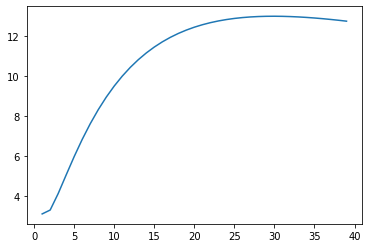

In [29]:
import matplotlib.pyplot as plt
t = np.log(np.linspace(0,2*np.pi,40))
x = np.sin(t)
y = x**2+5*x+7
plt.plot(np.abs(y))
plt.show()

Enter which trignometric function would be used in operations: cos


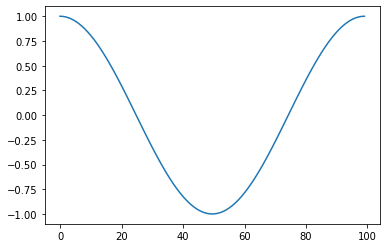

Enter which trignometric function would be used in operations: tan


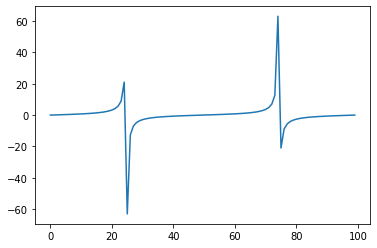

Enter which trignometric function would be used in operations: log


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


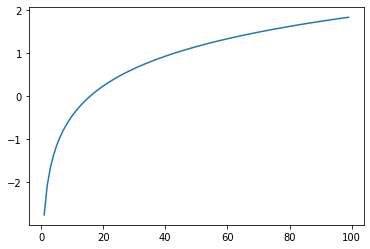

Enter which trignometric function would be used in operations: exp


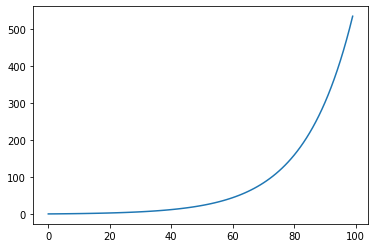

Enter which trignometric function would be used in operations: -1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
while True:
    x = input('Enter which trignometric function would be used in operations: ')
    t = np.linspace(0,2*np.pi,100)
    if 'tan' in x.lower():
        y = np.tan(t)
        plt.plot(y)
        plt.show()
    elif 'sin' in x.lower():
        y = np.sin(t)
        plt.plot(y)
        plt.show()
    elif 'cos' in x.lower():
        y = np.cos(t)
        plt.plot(y)
        plt.show()
    elif 'log' in x.lower():
        y = np.log(t)
        plt.plot(y)
        plt.show()
    elif 'exp' in x.lower():
        y = np.exp(t)
        plt.plot(y)
        plt.show()
    elif -1 == int(x):
        break
    else:
        print('Enter Sine, Cose, or tan operation only')

In [33]:
y

array([        nan,  3.09796941,  3.29245614,  4.11838069,  5.05401626,
        5.9732121 ,  6.83155745,  7.61406544,  8.31823413,  8.94705979,
        9.50584512, 10.00067306, 10.43766937, 10.822656  , 11.16100277,
       11.45758066, 11.7167661 , 11.94246999, 12.13817705, 12.30698819,
       12.45166195, 12.57465327, 12.67814866, 12.76409772, 12.83424107,
       12.89013487, 12.93317247, 12.96460324, 12.98554915, 12.9970192 ,
       12.99992214, 12.99507754, 12.98322556, 12.96503551, 12.94111338,
       12.91200851, 12.87821942, 12.84019905, 12.7983593 , 12.75307516])

<!--NAVIGATION-->
< [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb) | [Contents](Index.ipynb) | [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/02.03-Computation-on-arrays-ufuncs.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
